# Copyright Netherlands eScience Center <br>
** Function     : Predict the Spatial Sea Ice Concentration with BayesConvLSTM at weekly time scale** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2020.03.02 ** <br>
** Last Update  : 2020.03.09 ** <br>
** Library      : Pytorth, Numpy, NetCDF4, os, iris, cartopy, dlacs, matplotlib **<br>
Description     : This notebook serves to predict the Arctic sea ice using deep learning. The Bayesian Convolutional Long Short Time Memory neural network is used to deal with this spatial-temporal sequence problem. We use Pytorch as the deep learning framework. <br>
<br>
** Here we predict sea ice concentration with one extra relevant field from either ocean or atmosphere to test the predictor.** <br>

Return Values   : pkl model and figures <br>

The regionalization adopted here follows that of the MASIE (Multisensor Analyzed Sea Ice Extent) product available from the National Snow and Ice Data Center:<br>
https://nsidc.org/data/masie/browse_regions<br>
It is given by paper J.Walsh et. al., 2019. Benchmark seasonal prediction skill estimates based on regional indices.<br>

In [1]:
%matplotlib inline

import sys
import warnings
import numbers

# for data loading
import os
from netCDF4 import Dataset
# for pre-processing and machine learning
import numpy as np
import sklearn
#import scipy
import torch
import torch.nn.functional

#sys.path.append(os.path.join('C:','Users','nosta','ML4Climate','Scripts','DLACs'))
#sys.path.append("C:\\Users\\nosta\\ML4Climate\\Scripts\\DLACs")
sys.path.append("../../../../DLACs")
import dlacs
import dlacs.BayesConvLSTM
import dlacs.preprocess
import dlacs.function
import dlacs.saveNetCDF

# for visualization
import dlacs.visual
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import iris # also helps with regriding
import cartopy
import cartopy.crs as ccrs

# ignore all the DeprecationWarnings by pytorch
if not sys.warnoptions:
    warnings.simplefilter("ignore")

The testing device is Dell Inspirion 5680 with Intel Core i7-8700 x64 CPU and Nvidia GTX 1060 6GB GPU.<br>
Here is a benchmark about cpu v.s. gtx 1060 <br>
https://www.analyticsindiamag.com/deep-learning-tensorflow-benchmark-intel-i5-4210u-vs-geforce-nvidia-1060-6gb/

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2500000,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            'rho' : 1026,       # sea water density [kg/m3]
            }

** Data ** <br>
Time span of each product included: <br>
** Reanalysis ** <br>
- **ERA-Interim** 1979 - 2016 (ECMWF)
- **ORAS4**       1958 - 2014 (ECMWF)

** Index ** <br>
- **NINO3.4**     1950 - 2017 (NOAA)
- **AO**          1950 - 2017 (NOAA)
- **NAO**         1950 - 2017 (NOAA)
- **AMO**         1950 - 2017 (NOAA)
- **PDO**         1950 - 2017 (University of Washington)

!! These index are given by NCEP/NCAR Reanalysis (CDAS) <br>


Alternative (not in use yet) <br>
** Reanalysis ** <br>
- **MERRA2**      1980 - 2016 (NASA)
- **JRA55**       1979 - 2015 (JMA)
- **GLORYS2V3**   1993 - 2014 (Mercartor Ocean)
- **SODA3**       1980 - 2015
- **PIOMASS**     1980 - 2015

** Observations ** <br>
- **NSIDC**       1958 - 2017 

In [3]:
################################################################################# 
#########                           datapath                             ########
#################################################################################
# please specify data path
#datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ERA-Interim'
datapath_ERAI = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ERA-Interim'
#datapath_ORAS4 = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
datapath_ORAS4 = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ORAS4'
#datapath_ORAS4_mask = '/home/ESLT0068/WorkFlow/Core_Database_DeepLearn/ORAS4'
datapath_ORAS4_mask = 'H:\\Creator_Zone\\Core_Database_DeepLearn\\ORAS4'
#datapath_PIOMASS = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/PIOMASS'
#datapath_PIOMASS = 'H:\\Creator_Zone\\Core_Database_AMET_OMET_reanalysis\\PIOMASS'
#datapath_clim_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
#datapath_clim_index = 'F:\\PhD_essential\\Core_Database_AMET_OMET_reanalysis\\Climate_index'
#output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/ML4Climate/PredictArctic/BayesMaps'
output_path = 'C:\\Users\\nosta\\ML4Climate\\PredictArctic\\BayesMaps'

In [4]:
if __name__=="__main__":
    print ('*********************** get the key to the datasets *************************')
    # weekly variables on ERAI grid
    dataset_ERAI_fields_sic = Dataset(os.path.join(datapath_ERAI,
                                      'sic_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_slp = Dataset(os.path.join(datapath_ERAI,
#                                       'slp_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_t2m = Dataset(os.path.join(datapath_ERAI,
#                                       't2m_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_z500 = Dataset(os.path.join(datapath_ERAI,
#                                        'z500_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_z850 = Dataset(os.path.join(datapath_ERAI,
#                                        'z850_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_uv10m = Dataset(os.path.join(datapath_ERAI,
#                                        'uv10m_weekly_erai_1979_2017.nc'))
#     dataset_ERAI_fields_rad = Dataset(os.path.join(datapath_ERAI,
#                                         'rad_flux_weekly_erai_1979_2017.nc'))
    #dataset_PIOMASS_siv = Dataset(os.path.join(datapath_PIOMASS,
    #                             'siv_monthly_PIOMASS_1979_2017.nc'))
    # OHC interpolated on ERA-Interim grid
    dataset_ORAS4_OHC = Dataset(os.path.join(datapath_ORAS4,
                                'ohc_monthly_oras2erai_1978_2017.nc'))
#     dataset_index = Dataset(os.path.join(datapath_clim_index,
#                             'index_climate_monthly_regress_1950_2017.nc'))
    #dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
    #                                  'surface_erai_monthly_regress_1979_2017_radiation.nc'))
    # mask
    dataset_ORAS4_mask = Dataset(os.path.join(datapath_ORAS4_mask, 'mesh_mask.nc'))
    print ('*********************** extract variables *************************')
    #################################################################################
    #########                        data gallery                           #########
    #################################################################################
    # we use time series from 1979 to 2016 (468 months in total)
    # training data: 1979 - 2013
    # validation: 2014 - 2016
    # variables list:
    # SIC (ERA-Interim) / SIV (PIOMASS) / SST (ERA-Interim) / ST (ERA-Interim) / OHC (ORAS4) / AO-NAO-AMO-NINO3.4 (NOAA)
    # integrals from spatial fields cover the area from 20N - 90N (4D fields [year, month, lat, lon])
    # *************************************************************************************** #
    # SIC (ERA-Interim) - benckmark
    SIC_ERAI = dataset_ERAI_fields_sic.variables['sic'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
    year_ERAI = dataset_ERAI_fields_sic.variables['year'][:-1]
    week_ERAI = dataset_ERAI_fields_sic.variables['week'][:]
    latitude_ERAI = dataset_ERAI_fields_sic.variables['latitude'][:]
    longitude_ERAI = dataset_ERAI_fields_sic.variables['longitude'][:]
    # T2M (ERA-Interim)
#     T2M_ERAI = dataset_ERAI_fields_t2m.variables['t2m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_t2m = dataset_ERAI_fields_t2m.variables['year'][:-1]
#     week_ERAI_t2m = dataset_ERAI_fields_t2m.variables['week'][:]
#     latitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['latitude'][:]
#     longitude_ERAI_t2m = dataset_ERAI_fields_t2m.variables['longitude'][:]
    # SLP (ERA-Interim)
#     SLP_ERAI = dataset_ERAI_fields_slp.variables['slp'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_slp = dataset_ERAI_fields_slp.variables['year'][:-1]
#     week_ERAI_slp = dataset_ERAI_fields_slp.variables['week'][:]
#     latitude_ERAI_slp = dataset_ERAI_fields_slp.variables['latitude'][:]
#     longitude_ERAI_slp = dataset_ERAI_fields_slp.variables['longitude'][:]
    # Z500 (ERA-Interim)
#     Z500_ERAI = dataset_ERAI_fields_z500.variables['z'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_z500 = dataset_ERAI_fields_z500.variables['year'][:-1]
#     week_ERAI_z500 = dataset_ERAI_fields_z500.variables['week'][:]
#     latitude_ERAI_z500 = dataset_ERAI_fields_z500.variables['latitude'][:]
#     longitude_ERAI_z500 = dataset_ERAI_fields_z500.variables['longitude'][:]
    # Z850 (ERA-Interim)
#     Z850_ERAI = dataset_ERAI_fields_z850.variables['z'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_z850 = dataset_ERAI_fields_z850.variables['year'][:-1]
#     week_ERAI_z850 = dataset_ERAI_fields_z850.variables['week'][:]
#     latitude_ERAI_z850 = dataset_ERAI_fields_z850.variables['latitude'][:]
#     longitude_ERAI_z850 = dataset_ERAI_fields_z850.variables['longitude'][:]
    # UV10M (ERA-Interim)
#     U10M_ERAI = dataset_ERAI_fields_uv10m.variables['u10m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
#     V10M_ERAI = dataset_ERAI_fields_uv10m.variables['v10m'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['year'][:-1]
#     week_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['week'][:]
#     latitude_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['latitude'][:]
#     longitude_ERAI_uv10m = dataset_ERAI_fields_uv10m.variables['longitude'][:]
    # SFlux (ERA-Interim)
#     SFlux_ERAI = dataset_ERAI_fields_rad.variables['SFlux'][:-1,:,:,:] # 4D fields [year, week, lat, lon]
#     year_ERAI_SFlux = dataset_ERAI_fields_rad.variables['year'][:-1]
#     week_ERAI_SFlux = dataset_ERAI_fields_rad.variables['week'][:]
#     latitude_ERAI_SFlux = dataset_ERAI_fields_rad.variables['latitude'][:]
#     longitude_ERAI_SFlux = dataset_ERAI_fields_rad.variables['longitude'][:]
    #SIV (PIOMASS)
    #SIV_PIOMASS = dataset_PIOMASS_siv.variables['SIV'][:-12]
    #year_SIV = dataset_PIOMASS_siv.variables['year'][:-1]
    # OHC (ORAS4)
    # from 1978 - 2017 (for interpolation) / from 90 N upto 40 N
    OHC_300_ORAS4 = dataset_ORAS4_OHC.variables['OHC'][:-1,:,:67,:]/1000 # unit Peta Joule
    latitude_ORAS4 = dataset_ORAS4_OHC.variables['latitude'][:]
    longitude_ORAS4 = dataset_ORAS4_OHC.variables['longitude'][:]
    mask_OHC = np.ma.getmask(OHC_300_ORAS4[0,0,:,:])
    # AO-NAO-AMO-NINO3.4 (NOAA)
#     AO = dataset_index.variables['AO'][348:-1] # from 1979 - 2017
#     NAO = dataset_index.variables['NAO'][348:-1]
#     NINO = dataset_index.variables['NINO'][348:-1]
#     AMO = dataset_index.variables['AMO'][348:-1]
#     PDO = dataset_index.variables['PDO'][348:-1]

*********************** get the key to the datasets *************************
*********************** extract variables *************************


In [ ]:
    # first check of grid
    print(latitude_ERAI)
    print(longitude_ERAI)
    print(longitude_ORAS4)

In [5]:
    #################################################################################
    ###########                 global land-sea mask                      ###########
    #################################################################################
    sea_ice_mask_global = np.ones((len(latitude_ERAI),len(longitude_ERAI)),dtype=float)
    sea_ice_mask_global[SIC_ERAI[0,0,:,:]==-1] = 0
    #################################################################################
    ###########                regionalization sea mask                   ###########
    #################################################################################
    print ('*********************** create mask *************************')
    # W:-156 E:-124 N:80 S:67
    mask_Beaufort = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:-156 N:80 S:66
    mask_Chukchi = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:146 E:180 N:80 S:67
    mask_EastSiberian = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:100 E:146 N:80 S:67
    mask_Laptev = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:60 E:100 N:80 S:67
    mask_Kara = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:18 E:60 N:80 S:64
    mask_Barents = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-44 E:18 N:80 S:55
    mask_Greenland = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    # W:-180 E:180 N:90 S:80
    mask_CenArctic = np.zeros((len(latitude_ERAI),len(longitude_ERAI)),dtype=int)
    print ('*********************** calc mask *************************')
    mask_Beaufort[13:31,32:76] = 1

    mask_Chukchi[13:32,0:32] = 1
    mask_Chukchi[13:32,-1] = 1

    mask_EastSiberian[13:31,434:479] = 1

    mask_Laptev[13:31,374:434] = 1

    mask_Kara[13:31,320:374] = 1

    mask_Barents[13:36,264:320] = 1

    mask_Greenland[13:47,179:264] = 1
    mask_Greenland[26:47,240:264] = 0

    mask_CenArctic[:13,:] = 1
    print ('*********************** packing *************************')
    mask_dict = {'Beaufort': mask_Beaufort[:,:],
                 'Chukchi': mask_Chukchi[:,:],
                 'EastSiberian': mask_EastSiberian[:,:],
                 'Laptev': mask_Laptev[:,:],
                 'Kara': mask_Kara[:,:],
                 'Barents': mask_Barents[:,:],
                 'Greenland': mask_Greenland[:,:],
                 'CenArctic': mask_CenArctic[:,:]}
    seas_namelist = ['Beaufort','Chukchi','EastSiberian','Laptev',
                     'Kara', 'Barents', 'Greenland','CenArctic']

*********************** create mask *************************
*********************** calc mask *************************
*********************** packing *************************


In [6]:
    #################################################################################
    ########                  temporal interpolation matrix                  ########
    #################################################################################
    # interpolate from monthly to weekly
    # original monthly data will be taken as the last week of the month
    OHC_300_ORAS4_weekly_series = np.zeros(SIC_ERAI.reshape(len(year_ERAI)*48,len(latitude_ERAI),len(longitude_ERAI)).shape,
                                           dtype=float)
    OHC_300_ORAS4_series= dlacs.preprocess.operator.unfold(OHC_300_ORAS4)
    # calculate the difference between two months
    OHC_300_ORAS4_deviation_series = (OHC_300_ORAS4_series[1:,:,:] - OHC_300_ORAS4_series[:-1,:,:]) / 4
    for i in np.arange(4):
        OHC_300_ORAS4_weekly_series[3-i::4,:,:] = OHC_300_ORAS4_series[12:,:,:] - i * OHC_300_ORAS4_deviation_series[11:,:,:]

In [7]:
    print ('******************  calculate extent from spatial fields  *******************')
    # size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_ERAI /
                                            360) / len(longitude_ERAI)
    dy = np.pi * constant['R'] / 480
    # calculate the sea ice area
    SIC_ERAI_area = np.zeros(SIC_ERAI.shape, dtype=float)
#     SFlux_ERAI_area = np.zeros(SFlux_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_ERAI[:])):
        # change the unit to terawatt
        SIC_ERAI_area[:,:,i,:] = SIC_ERAI[:,:,i,:]* dx[i] * dy / 1E+6 # unit km2
#         SFlux_ERAI_area[:,:,i,:] = SFlux_ERAI[:,:,i,:]* dx[i] * dy / 1E+12 # unit TeraWatt
    SIC_ERAI_area[SIC_ERAI_area<0] = 0 # switch the mask from -1 to 0
    print ('================  reshape input data into time series  =================')
    SIC_ERAI_area_series = dlacs.preprocess.operator.unfold(SIC_ERAI_area)
#     T2M_ERAI_series = dlacs.preprocess.operator.unfold(T2M_ERAI)
#     SLP_ERAI_series = dlacs.preprocess.operator.unfold(SLP_ERAI)
#     Z500_ERAI_series = dlacs.preprocess.operator.unfold(Z500_ERAI)
#     Z850_ERAI_series = dlacs.preprocess.operator.unfold(Z850_ERAI)
#     U10M_ERAI_series = dlacs.preprocess.operator.unfold(U10M_ERAI)
#     V10M_ERAI_series = dlacs.preprocess.operator.unfold(V10M_ERAI)
#     SFlux_ERAI_area_series = dlacs.preprocess.operator.unfold(SFlux_ERAI_area)

******************  calculate extent from spatial fields  *******************
================  reshape input data into time series  =================


In [8]:
    print ('******************  choose the fields from target region  *******************')
    # select land-sea mask
    sea_ice_mask_barents = sea_ice_mask_global[12:36,264:320]
    print ('******************  choose the fields from target region  *******************')
    # select the area between greenland and ice land for instance 60-70 N / 44-18 W
    sic_exp = SIC_ERAI_area_series[:,12:36,264:320]
#     t2m_exp = T2M_ERAI_series[:,12:36,264:320]
#     slp_exp = SLP_ERAI_series[:,12:36,264:320]
#     z500_exp = Z500_ERAI_series[:,12:36,264:320]
#     z850_exp = Z850_ERAI_series[:,12:36,264:320]
#     u10m_exp = U10M_ERAI_series[:,12:36,264:320]
#     v10m_exp = V10M_ERAI_series[:,12:36,264:320]
#     sflux_exp = SFlux_ERAI_area_series[:,12:36,264:320]
    ohc_exp = OHC_300_ORAS4_weekly_series[:,12:36,264:320]
    print(sic_exp.shape)
#     print(t2m_exp.shape)
#     print(slp_exp.shape)
#     print(z500_exp.shape)
#     print(u10m_exp.shape)
#     print(v10m_exp.shape)
#     print(sflux_exp.shape)
    print(ohc_exp.shape)
    print(latitude_ERAI[12:36])
    print(longitude_ERAI[264:320])
    print(latitude_ORAS4[12:36])
    print(longitude_ORAS4[264:320])
    #print(latitude_ERAI[26:40])
    #print(longitude_ERAI[180:216])
    #print(sic_exp[:])

******************  choose the fields from target region  *******************
******************  choose the fields from target region  *******************
(1824, 24, 56)
(1824, 24, 56)
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   39.75 40.5  41.25 42.   42.75 43.5  44.25
 45.   45.75 46.5  47.25 48.   48.75 49.5  50.25 51.   51.75 52.5  53.25
 54.   54.75 55.5  56.25 57.   57.75 58.5  59.25]
[80.5  79.75 79.   78.25 77.5  76.75 76.   75.25 74.5  73.75 73.   72.25
 71.5  70.75 70.   69.25 68.5  67.75 67.   66.25 65.5  64.75 64.   63.25]
[18.   18.75 19.5  20.25 21.   21.75 22.5  23.25 24.   24.75 25.5  26.25
 27.   27.75 28.5  29.25 30.   30.75 31.5  32.25 33.   33.75 34.5  35.25
 36.   36.75 37.5  38.25 39.   3

In [9]:
    print ('*******************  pre-processing  *********************')
    print ('=========================   normalize data   ===========================')
    sic_exp_norm = dlacs.preprocess.operator.normalize(sic_exp)
#     t2m_exp_norm = deepclim.preprocess.operator.normalize(t2m_exp)
#     slp_exp_norm = deepclim.preprocess.operator.normalize(slp_exp)
#     z500_exp_norm = deepclim.preprocess.operator.normalize(z500_exp)
#     z850_exp_norm = deepclim.preprocess.operator.normalize(z850_exp)
#     u10m_exp_norm = deepclim.preprocess.operator.normalize(u10m_exp)
#     v10m_exp_norm = deepclim.preprocess.operator.normalize(v10m_exp)
#     sflux_exp_norm = deepclim.preprocess.operator.normalize(sflux_exp)
    ohc_exp_norm = dlacs.preprocess.operator.normalize(ohc_exp)
    print('================  save the normalizing factor  =================')
    sic_max = np.amax(sic_exp)
    sic_min = np.amin(sic_exp)
    print(sic_max,"km2")
    print(sic_min,"km2")
    print ('====================    A series of time (index)    ====================')
    _, yy, xx = sic_exp_norm.shape # get the lat lon dimension
    year = np.arange(1979,2017,1)
    year_cycle = np.repeat(year,48)
    month_cycle = np.repeat(np.arange(1,13,1),4)
    month_cycle = np.tile(month_cycle,len(year)+1) # one extra repeat for lead time dependent prediction
    month_cycle.astype(float)
    month_2D = np.repeat(month_cycle[:,np.newaxis],yy,1)
    month_exp = np.repeat(month_2D[:,:,np.newaxis],xx,2)
    print ('===================  artificial data for evaluation ====================')
    # calculate climatology of SIC
#     seansonal_cycle_SIC = np.zeros(48,dtype=float)
#     for i in np.arange(48):
#         seansonal_cycle_SIC[i] = np.mean(SIC_ERAI_sum_norm[i::48],axis=0)
    # weight for loss
#     weight_month = np.array([0,1,1,
#                              1,0,0,
#                              1,1,1,
#                              0,0,0])
    #weight_loss = np.repeat(weight_month,4)
    #weight_loss = np.tile(weight_loss,len(year))

*******************  pre-processing  *********************
=========================   normalize data   ===========================
================  save the normalizing factor  =================
1565.2049481856002 km2
0.0 km2
====================    A series of time (index)    ====================
===================  artificial data for evaluation ====================


1565.2049481856002
0.0
(1824, 24, 56)
[[251.4346045  251.05600413 250.50871172 ... 244.2139345  244.13173904
  244.01692955]
 [246.64799721 246.04600942 245.45885542 ... 245.36829478 245.24715214
  245.12353721]
 [246.7402512  247.31849816 248.16998491 ... 246.47754407 246.37387686
  246.26773736]
 ...
 [271.39089775 271.56084288 271.75937185 ... 272.40565781 271.30805881
  270.25455477]
 [271.93968032 272.07067828 272.09157428 ... 273.35488503 272.4173081
  271.39831464]
 [272.82825155 272.92514534 272.69329114 ... 274.15672261 273.34753587
  272.70551716]]
(24, 56)


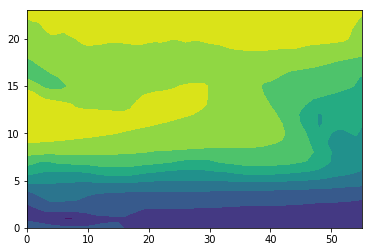

In [24]:
    print(t2m_exp.shape)
    ax = plt.contourf(t2m_exp[443,:,:])
    print(t2m_exp[443,:,:])
    print(month_exp[0,:,:].shape)

In [17]:
    print ('*******************  pretest input shape  *********************')
    x_input = np.stack((sic_exp_norm[1,:,:],
                        t2m_exp_norm[1,:,:],
                        ohc_exp_norm[1,:,:],
                        month_exp[1,:,:]))
    print(x_input[1,:,:])
    print(x_input[:].shape)

[[0.26267704 0.26046318 0.25661401 ... 0.22950646 0.22708498 0.22442972]
 [0.20302922 0.20179229 0.20073181 ... 0.23818486 0.23636252 0.23451899]
 [0.19524795 0.20810658 0.22415041 ... 0.25322432 0.25219251 0.25112267]
 ...
 [0.48474634 0.48954066 0.49081374 ... 0.36213768 0.336037   0.3028926 ]
 [0.49387301 0.5059012  0.52108218 ... 0.37193518 0.34423099 0.31239209]
 [0.52729484 0.54777388 0.5776589  ... 0.38700331 0.35481465 0.32946398]]
(4, 24, 56)


# Procedure for LSTM <br>
** We use Pytorth to implement LSTM neural network with time series of climate data. ** <br>

In [10]:
    print ('*******************  parameter for check  *********************')
    choice_exp_norm = ohc_exp_norm
    print ('*******************  create basic dimensions for tensor and network  *********************')
    # specifications of neural network
    input_channels = 3
    hidden_channels = [3, 2, 1] # number of channels & hidden layers, the channels of last layer is the channels of output, too
    #hidden_channels = [3, 3, 3, 3, 2]
    #hidden_channels = [2]
    kernel_size = 3
    # here we input a sequence and predict the next step only
    #step = 1 # how many steps to predict ahead
    #effective_step = [0] # step to output
    batch_size = 1
    #num_layers = 1
    learning_rate = 0.01
    num_epochs = 1500
    print ('*******************  cross validation and testing data  *********************')
    # take 10% data as cross-validation data
    cross_valid_year = 4
    # take 10% years as testing data
    test_year = 4
    # minibatch
    #iterations = 3 # training data divided into 3 sets

*******************  parameter for check  *********************
*******************  create basic dimensions for tensor and network  *********************
*******************  cross validation and testing data  *********************


In [11]:
    print ('*******************  check the environment  *********************')
    print ("Pytorch version {}".format(torch.__version__))
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()
    print("Is CUDA available? {}".format(use_cuda))
    # CUDA settings torch.__version__ must > 0.4
    # !!! This is important for the model!!! The first option is gpu
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    

*******************  check the environment  *********************
Pytorch version 1.1.0
Is CUDA available? True


In [12]:
    print ('*******************  preview of input tensor  *********************')
    #plt.plot(SIC_ERAI_sum)
    #print(SIC_ERAI_sum_norm[:-test_year*12])
    #print(x_input.shape)
    #print(x_input[:,:,:])
    sequence_len, _, _ = sic_exp_norm.shape
    print(sequence_len)

*******************  preview of input tensor  *********************
1824


In [ ]:
#     print ('*******************  module for calculating accuracy  *********************')
#     def accuracy(out, labels):
#         outputs = np.argmax(out, axis=1)
#     return np.sum(outputs==labels)/float(labels.size)

In [13]:
    %%time
    print ('*******************  load exsited LSTM model  *********************')
    # load model parameters
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    model.load_state_dict(torch.load(os.path.join(output_path, 'map_BayesConvLSTM_sic_ohc_Barents_hl_3_kernel_3_lr_0.01_epoch_1500_validSIC.pkl'),
                                     map_location=device))
    # load entire model
    #model = torch.load(os.path.join(output_path, 'Barents','convlstm_era_sic_oras_ohc_Barents_hl_3_kernel_3_lr_0.005_epoch_1500_validSIC.pkl'))
    print(model)
    # check the sequence length (dimension in need for post-processing)
    sequence_len, height, width = sic_exp_norm.shape

*******************  load exsited LSTM model  *********************
BayesConvLSTM(
  (cell0): BayesConvLSTMCell()
  (cell1): BayesConvLSTMCell()
  (cell2): BayesConvLSTMCell()
)
Wall time: 7.61 s


In [12]:
    print ('*******************  run BayesConvLSTM  *********************')
    print ('The model is designed to make many to one prediction.')
    print ('A series of multi-chanel variables will be input to the model.')
    print ('The model learns by verifying the output at each timestep.')
    # check the sequence length
    sequence_len, height, width = sic_exp_norm.shape
    # initialize our model
    model = dlacs.BayesConvLSTM.BayesConvLSTM(input_channels, hidden_channels, kernel_size).to(device)
    # use Evidence Lower Bound (ELBO) to quantify the loss
    ELBO = dlacs.function.ELBO(height*width)
    # for classification, target must be integers (label)
    #ELBO = dlacs.function.ELBO(height*width,loss_function=torch.nn.KLDivLoss())
    #ELBO = dlacs.function.ELBO(height*width,loss_function=nn.CrossEntropyLoss(reduction='mean'))
    #ELBO = dlacs.function.ELBO(height*width,loss_function=nn.NLLLoss(reduction='mean'))
    # penalty for kl
    penalty_kl = sequence_len
    # stochastic gradient descent
    #optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Adam optimizer
    optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)
    print(model)
    print(ELBO)
    print(optimiser)

*******************  run BayesConvLSTM  *********************
The model is designed to make many to one prediction.
A series of multi-chanel variables will be input to the model.
The model learns by verifying the output at each timestep.
BayesConvLSTM(
  (cell0): BayesConvLSTMCell()
  (cell1): BayesConvLSTMCell()
  (cell2): BayesConvLSTMCell()
)
ELBO(
  (loss_function): MSELoss()
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


In [13]:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print (name)
            print (param.data)
            print (param.size())
            print ("=========================")

cell0.Wxi_mu
tensor([[[[ 0.1493, -0.1049, -0.1169],
          [ 0.1776,  0.1855,  0.1521],
          [-0.1421, -0.0015, -0.1056]],

         [[ 0.1557,  0.1495,  0.0020],
          [ 0.0067, -0.1735, -0.0694],
          [-0.1377,  0.0168, -0.0152]],

         [[ 0.0997,  0.1372, -0.1340],
          [-0.1373, -0.1903, -0.1407],
          [-0.0639,  0.1652, -0.0235]]],


        [[[ 0.0721,  0.1496,  0.0010],
          [-0.0476, -0.1298, -0.0505],
          [-0.0263,  0.0179,  0.1862]],

         [[-0.1127, -0.1066,  0.1058],
          [-0.0141,  0.0440, -0.0584],
          [ 0.1735,  0.1856, -0.0975]],

         [[ 0.1118,  0.0193, -0.0664],
          [-0.1332,  0.0209, -0.1522],
          [-0.0414, -0.1464, -0.0622]]],


        [[[ 0.1902, -0.1409,  0.0700],
          [ 0.1098, -0.0669,  0.0604],
          [-0.0547,  0.1620,  0.0425]],

         [[ 0.1181, -0.0449,  0.1699],
          [ 0.0937,  0.0864,  0.1234],
          [-0.0494,  0.0644,  0.0339]],

         [[ 0.0069,  0.1626,  0

          [ 0.0852,  0.1078,  0.1185]]]], device='cuda:0')
torch.Size([3, 3, 3, 3])
cell0.Wxi_bias
tensor([ 0.0244, -0.0210, -0.1620], device='cuda:0')
torch.Size([3])
cell0.Wxf_bias
tensor([-0.0954, -0.1107,  0.0890], device='cuda:0')
torch.Size([3])
cell0.Wxc_bias
tensor([0.0300, 0.1512, 0.0764], device='cuda:0')
torch.Size([3])
cell0.Wxo_bias
tensor([ 0.1602,  0.1820, -0.0192], device='cuda:0')
torch.Size([3])
cell0.Wxi_log_var
tensor([[[[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]],

         [[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]],

         [[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]]],


        [[[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]],

         [[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]],

         [[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]]],


        [[[-3., -3., -3.],
          [-3., -3., -3.],
         

          [-9.1147e-02, -2.8623e-02,  1.0912e-02]]]], device='cuda:0')
torch.Size([2, 2, 3, 3])
cell1.Wxf_mu
tensor([[[[-0.0750, -0.1233, -0.1644],
          [ 0.1721,  0.0521,  0.0610],
          [-0.1810,  0.1158,  0.1859]],

         [[ 0.1627,  0.1428,  0.0907],
          [ 0.1298,  0.1200,  0.1550],
          [ 0.1307,  0.0186, -0.0026]],

         [[ 0.1204, -0.1486, -0.0690],
          [-0.1370,  0.1229, -0.1739],
          [-0.0768, -0.0490,  0.0715]]],


        [[[-0.0983,  0.0342, -0.1559],
          [ 0.1660,  0.1632, -0.0618],
          [ 0.1091, -0.1851, -0.0794]],

         [[-0.0923,  0.0473,  0.0742],
          [ 0.1295,  0.0118, -0.1301],
          [-0.0101, -0.0680,  0.0549]],

         [[-0.0614, -0.0265, -0.0590],
          [-0.0661, -0.1230,  0.1369],
          [ 0.1550, -0.0711,  0.1566]]]], device='cuda:0')
torch.Size([2, 3, 3, 3])
cell1.Whf_mu
tensor([[[[ 0.0253, -0.0917, -0.0742],
          [-0.0364, -0.1231,  0.1785],
          [ 0.0222, -0.0949,  0.0741]],



cell1.Who_log_var
tensor([[[[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]],

         [[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]]],


        [[[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]],

         [[-3., -3., -3.],
          [-3., -3., -3.],
          [-3., -3., -3.]]]], device='cuda:0')
torch.Size([2, 2, 3, 3])
cell2.Wxi_mu
tensor([[[[-0.1891, -0.2187,  0.1254],
          [-0.0066,  0.1957,  0.1143],
          [-0.2314, -0.0861, -0.1239]],

         [[ 0.0534, -0.2034,  0.0671],
          [-0.0413,  0.0302,  0.0005],
          [ 0.0208, -0.0249, -0.1375]]]], device='cuda:0')
torch.Size([1, 2, 3, 3])
cell2.Whi_mu
tensor([[[[ 0.0369,  0.0665,  0.0651],
          [ 0.0183, -0.0760, -0.0385],
          [ 0.0755,  0.2185, -0.1084]]]], device='cuda:0')
torch.Size([1, 1, 3, 3])
cell2.Wxf_mu
tensor([[[[-0.0874, -0.1304,  0.1828],
          [-0.1038, -0.0547,  0.1788],
          [-0.1218, -0.0223, -0.2084]],

    

In [15]:
    print('##############################################################')
    print('#############  preview model parameters matrix  ###############')
    print('##############################################################')
    print('Number of parameter matrices: ', len(list(model.parameters())))
    for i in range(len(list(model.parameters()))):
        print(list(model.parameters())[i].size())

##############################################################
#############  preview model parameters matrix  ###############
##############################################################
Number of parameter matrices:  60
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([3, 3, 3, 3])
torch.Size([2, 3, 3, 3])
torch.Size([2, 2, 3, 3])
torch.Size([2, 3, 3, 3])
torch.Size([2, 2, 3, 3])
torch.Size([2, 3, 3, 3])
torch.Size([2, 2, 3, 3])
torch.Size([2, 3, 3, 3])
torch.Size([2, 2, 3, 3])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2])
torch.Size([2, 3, 3, 3])
torch.Size([2, 3, 3, 3]

In [14]:
    %%time
    print('##############################################################')
    print('##################  start training loop  #####################')
    print('##############################################################')
    # track training loss
    hist = np.zeros(num_epochs)
    # loop of epoch
    for t in range(num_epochs):
        # Clear stored gradient
        model.zero_grad()
        # loop of timestep
        for timestep in range(sequence_len - cross_valid_year*12*4 - test_year*12*4):
            # hidden state re-initialized inside the model when timestep=0
            #################################################################################
            ########          create input tensor with multi-input dimension         ########
            #################################################################################
            # create variables
            x_input = np.stack((sic_exp_norm[timestep,:,:],
                                choice_exp_norm[timestep,:,:],
                                month_exp[timestep,:,:])) #vstack,hstack,dstack
            x_var = torch.autograd.Variable(torch.Tensor(x_input).view(-1,input_channels,height,width)).to(device)
            #################################################################################
            ########       create training tensor with multi-input dimension         ########
            #################################################################################
            y_train_stack = sic_exp_norm[timestep+1,:,:] #vstack,hstack,dstack
            y_var = torch.autograd.Variable(torch.Tensor(y_train_stack).view(-1,hidden_channels[-1],height,width)).to(device)
            #################################################################################   
            # Forward pass
            y_pred, kl_loss, _ = model(x_var, timestep)
            # choose training data
            y_target = y_var
            # torch.nn.functional.mse_loss(y_pred, y_train) can work with (scalar,vector) & (vector,vector)
            # Please Make Sure y_pred & y_train have the same dimension
            # accumulate loss
            if timestep == 0:
                loss = ELBO(y_pred, y_target, kl_loss, 1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
            else:
                loss += ELBO(y_pred, y_target, kl_loss, 1 / (len(hidden_channels) * 8 * penalty_kl * kernel_size**2))
            #print (timestep)
        #print(y_pred.shape)
        #print(y_train.shape)
        # print loss at certain iteration
        if t % 5 == 0:
            print("Epoch ", t, "MSE: ", loss.item())
            #print(y_pred)
            # gradient check
            # Gradcheck requires double precision numbers to run
            #res = torch.autograd.gradcheck(loss_fn, (y_pred.double(), y_train.double()), eps=1e-6, raise_exception=True)
            #print(res)
        hist[t] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()
    
        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    # save the model
    # (recommended) save the model parameters only
    torch.save(model.state_dict(), os.path.join(output_path,'bayesconvlstm.pkl'))
    # save the entire model
    # torch.save(model, os.path.join(output_path,'bayesconvlstm.pkl'))

##############################################################
##################  start training loop  #####################
##############################################################
Epoch  0 MSE:  79923.5234375


KeyboardInterrupt: 

*******************  Loss with time  **********************


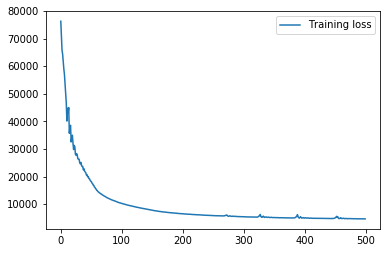

In [14]:
    print ("*******************  Loss with time  **********************")
    fig00 = plt.figure()
    try:
        plt.plot(hist, label="Training loss")
        plt.legend()
        plt.show()
        fig00.savefig(os.path.join(output_path,'SIC_ERAI_LSTM_pred_error.png'),dpi=200)
    except:
        print('Model is reloaded instead of trained!')